Sarthak Kapoor - MSc SiSc
(Mat# 416194)

# Introduction

Within the bounds of Project 1 for the course 'Fast Iterative Solvers' given by Prof. Georg May at RWTH Aachen, two popular Krylov-space methods for solving linear systems have been implemented: Generalized Minimum Residual (GMRES) and Conjugate Gradients (CG). These methods iteratively find the best solution x for the given linear system Ax = b. 

Particular to our interest are the linear systems with large sparse matrices A stored in Compressed Row Format (CRS) format. We have used two such matrices imported from MatrixMarket (.mtx format): <a href ='https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/oilgen/orsirr_1.html#download'>ORSIRR 1</a> and <a href ='https://math.nist.gov/MatrixMarket/data/misc/cylshell/s3rmt3m3.html'>S3RMT3M3</a>. These matrices are non-symmetric and symmetric respectively. 

GMRES in two modes, i.e. full and restarted, is used for the non-symmetric matrix and CG is used for the symmetric matrix. Additionally, we have implemented two types of preconditioning, i.e. Jacobi and Gauss-Seidel, for the GMRES method.  



# Helper functions (and some library imports)

The following libraries have been imported-
1. scipy.io (to read .mtx file) 
2. matplotlib.pyplot (to plot results)
3. time (to calculate time of computation)

The following functions have been written to help GMRES and CG algorithm-
1.  `add(a,b)` - adds two vectors a and b
2.  `constMultiply(a,b)` - multiplies vector a with constant b
3.  `dotProduct(a,b)` - calculates dot product of vectors a and b
4.  `norm(a)` - calculates norm of vector a
5.  `transpose(a)` - calculates transpose of matrix a
6.  `backSub(a,b)` - calculates back substitution to solve ax=b where a is upper triangular matrix in dense format
7.  `symmetric(a)` - returns bool `True` if a is symmetric, otherwise `False`
8.  `matVecProduct(a,b)` - multiplies matrix a (in dense format) with vector b
9.  `diagonalInverseMultCRS(A, b)` - for diagonal matrix A in CRS format, finds the product inv(A)*b
10. `lowerTriangleCRS(A)` - extracts the lower triangle with diagonal from matrix A in CRS format
11. `forwardSubCRS(A,b)` - calculates forward substitution to solve Ax=b where A is lower triangular matrix in CRS format

In [1]:
import scipy.io as sio                  # library is needed to read mtx into dense format
import matplotlib.pyplot as plt
import time

def add(a,b):
    x = [0 for i in range(len(a))]
    for i in range(len(a)):
        x[i]=a[i]+b[i]
    return x

def constMultiply(a,b):
    return [i*b for i in a]

def dotProduct(a,b):
    dot=0
    for i in range(len(a)):
        dot = dot + a[i]*b[i]
    return dot

def norm(a):
    return dotProduct(a,a)**0.5

def transpose(a):
    aT= [[0 for i in range(len(a))] for j in range(len(a[0]))]
    # calculating the transpose
    for i in range(len(a[0])):
        for j in range(len(a)):
            aT[i][j]=a[j][i]
    return aT

def backSub(A,b):
    
    x = [0]*len(b)
    for i in range(len(A)-1,-1,-1):
        x[i] = b[i]
        for j in range(len(A)-i-1):
            x[i] = x[i] - A[i][len(A)-1-j]*x[len(A)-1-j]
        
        x[i] = x[i]/A[i][i]
    
    return x

def symmetric(a):
    aT= transpose(a)
    # comparing the elements and returning 'not symmetric' at the first unequal corresponding elements
    for i in range(len(a)):
        for j in range(len(a[0])):
            if (aT[i][j] != a[i][j]):
                return False
    # return 'symmetric' if all the corresponding elements are equal
    return True

def matVecProduct(a,b):
    if len(a[0]) != len(b):
        print("matVecProduct: Error in dimensions.")
        return 0
    else:
        x=[]
        for i in range(len(a)):
            x.append(dotProduct(a[i],b))
        return x
    
def diagonalInverseMultCRS(A, b):
    # algorithm breaksdown if any of the diagonal elements is zero
    I = A[0]
    J = A[1]
    V = A[2]
    d = []
    
    for i in range(len(I)-1):
        i1 = I[i]
        i2 = I[i+1]
        if i2-i1>0:
            for j in range(i1, i2):
                if J[j]==i:
                    d.append(V[j])
                    break
        
    #print(d)
    if len(d) != len(b):
        print("Error in diagonalInverseMultCRS")
        #exit()
                    
    for i in range(len(d)):
        b[i]= b[i]/d[i]
    
    return b


def lowerTriangleCRS(A):
    # extracting lower triangle from matrix A stored in CRS format
    I = A[0]
    J = A[1]
    V = A[2]
    
    LI = [0]
    LJ = []
    LV = []
    
    count=0
    for i in range(len(I)-1):
        i1 = I[i]
        i2 = I[i+1]
        
        for j in range(i1,i2):
            if J[j] > i:
                break
            count=count+1
            LJ.append(J[j])
            LV.append(V[j])
        
        LI.append(count)
    
    L = [LI,LJ,LV, False]                  # False = non-symmetric matrix
    
    return L

def forwardSubCRS(A,b):
    # A is a lower triangular matrix
    I = A[0]
    J = A[1]
    V = A[2]
    x = [0]*len(b)
    
    for i in range(len(I)-1):
        i1 = I[i]
        i2 = I[i+1]
        
        x[i] = b[i]
        
        for j in range(i2-i1-1):
            x[i] = x[i] - V[i1+j]*x[j] 
  
        x[i] = x[i] / V[i2-1]
        
    return x

# Implementations for using CRS format

We have implemented a function `denseToCRS` that converts a dense matrix into Compressed Row Format (CRS). CRS is a memory efficient format for storing sparse matrices and includes three arrays-
1. Index array (I) that stores the the cummulative number of non-zero elements at the end of every row. Array I has an additional first element as zero. It's the only array among the three for which the length is is known, i.e., M+1, where M is the number of rows of the martix.
2. Column array (J) that stores the column index for each row (ascending order) which has a non-zero element.
3. Value array (V) that stores all the non-zero entries. 

The size of arrays J and V is same. In addition to these three outputs, we generate an extra output that tells if the matrix stored in CRS format is symmetric or non-symmetric. 

Function `denseToCRS` only stores the lower triangle (with diagonal) for symmetric matrices.

Note: As scipy imports .mtx as an object, the author couldn't find a way to get pure COO output in a list.  Therefore, he used .toarray() method to get matrix in dense format, after which the matrix was converted from dense to CRS format.   


In [1]:
### function written way after project submission deadline :(
### reads .mtx file directly into CRS format
### no need to scipy.io library

def readmtxCRS(filename, sym=True):
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('%'):
                continue                           # ignoring the comments in file
            meta = [int(i) for i in line.split()]  # storing the meta data
            break
        
        coo = []
        
        for line in f:
            coo.append([float(i) for i in line.split()])
            coo[-1][0] = int(coo[-1][0])
            coo[-1][1] = int(coo[-1][1])
    
    coo.sort()              # to sort the list with respect to rows   
    
    index=0
    i_old = 1
    I=[index];              # first element of I is 0
    J=[]; V=[] 
    
    if sym:
        for row in coo:
            if row[0]<row[1]:
                continue
            if row[0]!=i_old:
                I.append(index)
                i_old = row[0]
            index+=1
            J.append(row[1]-1)
            V.append(row[2])
        I.append(index)
    
    else:
        for row in coo:
            if row[0]!=i_old:
                I.append(index)
                i_old = row[0]
            index+=1
            J.append(row[1]-1)
            V.append(row[2])
        I.append(index)
            
    A=[I, J, V, symmetric]       
    
    return A
    
def denseToCRS(a):
    
    # denseToCRS(a) takes input of dense matrix and returns A in CRS format
    # A contains 3 lists and 1 bool: 
    # lists containing the array I, array J and array V
    # bool containing True if matrix is symmetric, otherwise False
    
    index=0
    I=[index];                          # first element of I is 0
    J=[]; V=[] 
    
    sym=symmetric(a)                    # determine whether 'a' is symmetric or not  
    
    if (sym):
        print("-> Symmetric", flush=True)
        for i in range(len(a)):
            for j in range(i+1):        # for symmetric case, going over only the lower triangle
                val=a[i][j]
                if (val!=0):
                    index=index+1       # counting number of non-zero elements per row
                    J.append(j)         # appending J with the column number for the respective non-zero element
                    V.append(val)       # appending V with the value of respective non-zero element
            I.append(index)             # appending I which number of non-zero elements per row
    else:
        print("-> Non-symmetric", flush=True)
        for i in range(len(a)):
            for j in range(len(a[0])):  # going over all the matrix elements
                val=a[i][j]
                if (val!=0):
                    index=index+1
                    J.append(j)
                    V.append(val)
            I.append(index)
            
    A=[I, J, V, sym]        
    print("-> Converted to CRS format\n-> Length of vectors I,J,V: ", len(I),len(J),len(V), flush=True)
    
    
    return A


Next, we have implemented `matVecProductCRS` that computes the matrix-vector product where matrix is stored in CRS format. The function treats symmetric and non-symmetric matrices differently as they are differently stored in CRS format.  

In [3]:
def matVecProductCRS(A,x):
    ''' A is in CRS format with arguments [I,J,V,sym] and x is a vector
        we compute the matrix vector product with CRS algorithm for non-symmetric
        and using CRS-CCS (compressed column storage) algorithm for symmetric
    '''
    # taking I,J,V,sym values from A matrix
    I=A[0]
    J=A[1]
    V=A[2]
    sym=A[3]
    y=[]
    
    if len(A[0])!=len(x)+1:
        print("matVecProductCRS: Error in dimensions.")
        return 0;
    
    # non-symmetric case
    if sym==False:                        
        for i in range(len(I)-1):         # len(I)-1 keeps the iter i2 within bounds
            i1=I[i]
            i2=I[i+1]
            
            # calculating dot product of given matrix row with vector x
            # V[i1:i2] slices the non-zero elements values present in the i-th row
            # J[i1:i2] slices the column indices for those elements
            # x[j] gives vector elements that will multiply with non-zero matrix elements from i-th row
            dot=dotProduct(V[i1:i2],[x[j] for j in J[i1:i2]])
            
            # appending the i-th element of solution vector
            y.append(dot)
    
    # symmetric case
    else:   
        
        # processing symmetric matrices in two parts
        # lower triangle (ignoring diagonal) is computed over using CRS-matVecProduct algorithm over stored CRS entries
        # upper triangle (with diagonal) is computed over using CCS-matVecProduct algorithm over stored CRS entries
        
        for i in range(len(I)-1):
            i1=I[i]
            i2=I[i+1]-1                     # i1:i2-1  will skip diagnal entries from the matrix
            
            dot=dotProduct(V[i1:i2],[x[j] for j in J[i1:i2]])     
            y.append(dot)

        for i in range(len(I)-1):
            i1=I[i]
            i2=I[i+1]
           
            v=V[i1:i2]
            
            i3=0
            for j in J[i1:i2]:
                y[j] = y[j] + v[i3]*x[i]    # CCS-matVecProduct algorithm
                i3=i3+1

    return y

## Small tests
Testing matVecProductCRS(A_crs, x) by comparing it with matVecProduct(A_dense, x) for 4x4 matrices, both non-symmetric and symmetric cases. 


### For non-symmetric case

In [4]:
A = [[16, -2, -12, -16], [-12, 25, 12, -4], [-11, 1, 17, 14], [-16, -4, 14, 57]]
x= [3, 1, 1, 2]

print("A: \n[ ", A[0], ", \n", A[1], ", \n", A[2], ", \n", A[3], " ]")
print("x: \n", x)

print("\nUsing matVecProduct(A,x) \nAx =", matVecProduct(A,x))

print("\nConverting A from dense to CRS: ")
A = denseToCRS(A)
print("\nUsing matVecProdcutCRS(A,x): \nAx =", matVecProductCRS(A,x))

print("\nBoth the results are consistent")

A: 
[  [16, -2, -12, -16] , 
 [-12, 25, 12, -4] , 
 [-11, 1, 17, 14] , 
 [-16, -4, 14, 57]  ]
x: 
 [3, 1, 1, 2]

Using matVecProduct(A,x) 
Ax = [2, -7, 13, 76]

Converting A from dense to CRS: 
-> Non-symmetric
-> Converted to CRS format
-> Length of vectors I,J,V:  5 16 16

Using matVecProdcutCRS(A,x): 
Ax = [2, -7, 13, 76]

Both the results are consistent


### For symmetric case 

In [5]:
A = [[6, -12, -12, -16], [-12, 25, 1, -4], [-12, 1, 17, 14], [-16, -4, 14, 57]]
x= [3, 1, 1, 2]

print("A: \n[ ", A[0], ", \n", A[1], ", \n", A[2], ", \n", A[3], " ]")
print("x: \n", x)

print("\nUsing matVecProduct(A,x) \nAx =", matVecProduct(A,x))

print("\nConverting A from dense to CRS: ")
A = denseToCRS(A)
print("\nUsing matVecProdcutCRS(A,x): \nAx =", matVecProductCRS(A,x))

print("\nBoth the results are consistent")

A: 
[  [6, -12, -12, -16] , 
 [-12, 25, 1, -4] , 
 [-12, 1, 17, 14] , 
 [-16, -4, 14, 57]  ]
x: 
 [3, 1, 1, 2]

Using matVecProduct(A,x) 
Ax = [-38, -18, 10, 76]

Converting A from dense to CRS: 
-> Symmetric
-> Converted to CRS format
-> Length of vectors I,J,V:  5 10 10

Using matVecProdcutCRS(A,x): 
Ax = [-38, -18, 10, 76]

Both the results are consistent


# Generalized Minimum Residual (GMRES) Method 

GMRES is a Krylov-space method that finds the solution of a linear system in an m-dimensional Krylov-space. This is done iteratively where a new basis vector is added to the Krylov-space in each iteration. This improves the solution approximation and the same is repeated until a certain relative residual is achieved (1e-8 in our case). 
K-space is expanded in each iteration using Gram Schmidt process which generates a vector that is orthogonal to all the previous vectors in the K-space. 

This has been implemented using `getKrylov` function, where a new vector is generated for an existing K-space. Additionally, we have implemented `GramSchmidt` that generates m-dimensional K-space from scratch (although this isn't used in the GMRES method).

In [6]:
def getKrylov(A,Vj):
    # A is the sparse matrix 
    # Vj is the matrix containing 1 to j orthonormal vectors (one row for each) for j-Krylov space. 
    # For ease of data access in Python Vj has vectors arranged row-wise (instead of col-wise which is usual notation in theory)
    
    vj= Vj[-1]                             # selecting the last row from Vj which is the j-th vector
    hj= [0 for i in range(len(Vj))]        # initiating hj with column size of Vj (total number of vectors)
    w = matVecProductCRS(A,vj)
    
    for i in range(len(Vj)):               # looping over all the vectors of Vj
        vi= Vj[i]                          # getting the i-th vector 
        hj[i]= dotProduct(w,vi)            # calculating non-independency of w with current orthonormal vector
        w = add(w, constMultiply(vi,-hj[i]))
                                           # removing the non-independency
    
    hj.append(norm(w))                     # adding norm of new vector 
    vjnext = constMultiply(w,1/hj[-1])
    
    return vjnext, hj
    
    
def GramSchmidt(A, r0, m):
    Vj=[]
    Hbar=[]
    v1= [i/norm(r0) for i in r0]           # v1 = r0/norm(r0)
    Vj.append(v1)
    for i in range(m):
        vjnext, hj = getKrylov(A,Vj)
        
        for num in range(m-1-i):
            hj.append(0)
            
        Vj.append(vjnext)
        Hbar.append(hj)
    Vj.pop()                              # remove the (m+1)th vector generated by GetKrylov
    
    print("-> Krylov space with ", m, " vectors generated. \n", flush=True)
        
    return Vj, Hbar; 

## Implementation of GMRES

`GMRES` function used the general algorithm without any specific way of implementation (like full-GMRES). It finds the solution in K-space that is spanned by upto `m` vectors. 

`fGMRES` function uses `GMRES` function with `m=1000` which is sufficiently high for our linear system to be converged. Therefore, `fGMRES` starts from the initial condition and iteratively increases the Krylov space till the relative residual cutoff condition is reached. `fGMRES` does not use any type of preconditioning. 

In [7]:
def GMRES(A,x0,b,m,verbose):
    # verbose is takes bool input
    # True = return a list of rho/rho0 at every iteration; False = returns rho/rho0 for last iteration 
    
    rholist=[]
    
    lhs= matVecProductCRS(A,x0)
    r0 = add(b,constMultiply(lhs,-1))     # r0 = b-(A)(x0)
    
    v1 = constMultiply(r0,1/norm(r0))     # v1 = r0/norm(r0)
    
    g = []                       # g vector
    g.append(norm(r0))
    rholist.append(norm(r0))
                          
    # for easy of access Vj and Hbar has vectors arranged row-wise (instead of col-wise which is usual notation in theory)
    
    Vj=[]
    Hbar=[]                       
    
    c = [0 for i in range(m)]
    s = [0 for i in range(m)]

    Vj.append(v1) 
    
    for j in range(m):
        
        vjnext, hj = getKrylov(A, Vj)
                
        for k in range(1,j+1): 
            val1   =  c[k-1]*hj[k-1] + s[k-1]*hj[k]
            val2   = -s[k-1]*hj[k-1] + c[k-1]*hj[k]
            hj[k-1]= val1
            hj[k]  = val2
    
        c[j]= hj[j]/(hj[j]**2 + hj[j+1]**2)**0.5
        s[j]= hj[j+1]/(hj[j]**2 + hj[j+1]**2)**0.5
    
        hj[j]= hj[j]*c[j] + hj[j+1]*s[j]
        #hj[j+1]=0                  # should be zero after rotation
    
        g.append(-s[j]*g[j])
        g[j]  =  c[j]*g[j]
            
        for num in range(m-1-j):
            hj.append(0)
            
        Hbar.append(hj)
        Vj.append(vjnext)
        
        if verbose == True:         # verbose=True is used for fGMRES where we need rholist to plot outside the function
            rholist.append(abs(g[j+1])/rholist[0])
            #print("Generated",j+1,"Krylov vectors. Relative residual=",abs(g[j+1])/rholist[0],flush=True)
            
        if abs(g[j+1])/rholist[0] < 1e-8:
            break
    
    if j!=m-1:                      # removing the rows containing all zeros in a case loops breaks before iterating m times
        Hbart=transpose(Hbar)
        for i in range(m-j-1):
            Hbart.pop()
        Hbar= transpose(Hbart)
    
    Vj.pop()                        # remove m+1 th vector

    rho= abs(g.pop())               # |g_m+1| is nothing but rm
    
    # removing the last row of Hbar giving Hm matrix
    Hbart=transpose(Hbar)
    Hbart.pop()                 
    H= transpose(Hbart)             # gives out transpose of Hm matrix

    xm = add(x0, matVecProduct(transpose(Vj), backSub(transpose(H),g)))
    
    if verbose == True:             # verbose=True is used for fGMRES where we need rholist to plot outside the function
        rho=rholist
        
    return xm, rho, Vj              # taking output of Vj to check orthogonality of Krylov vectors
    


In [8]:
def fGMRES(A,x0,b):
    
    start=time.time()
    cutoff = 1e-8                   # relative error cutoff
    m=1000                          # computation will stop after Krylov space with m vectors is generated
    
    x, rho, Vj = GMRES(A,x0,b,m,True)
        
    end=time.time()
    plt.semilogy(rho)
    plt.xlabel("Iterations")
    plt.ylabel("Relative residual (rho/rho0)")
    plt.show()
    
    if rho[-1] > 1e-8:
        print("-> Full GMRES did not converge after",m,"iterations. Relative residual =",rho[-1], "\n-> Time taken(s) =", end-start)
    else:
        print("-> Full GMRES converged in", len(Vj), "iterations (corresponds to the size of K-space). Relative residual =", rho[-1], "\n-> Time taken(s) =", end-start)   

    return x, rho, Vj               # taking output of Vj to check orthogonality of Krylov vectors



## Setting up the linear system for non-symmetric case
Next, we set up the linear system Ax=b where A is the sparse-matrix orsirr_1.mtx and x is [1,1,..,1]. 
b is computed using matrix-vector product Ax. Then, numerical solution for Ax = b is found using GMRES method.

In [9]:
A1_dense=sio.mmread("orsirr_1.mtx").toarray()
A1=denseToCRS(A1_dense)

xsol=[1 for i in range(1030)]
x0=[0 for i in range(1030)]
b= matVecProductCRS(A1,xsol)

-> Non-symmetric
-> Converted to CRS format
-> Length of vectors I,J,V:  1031 6858 6858


## Full-GMRES (without preconditioning)

`fGMRES` takes <u>512</u> Krylov vectors to converge with a cutoff for relative residual as 1e-8.

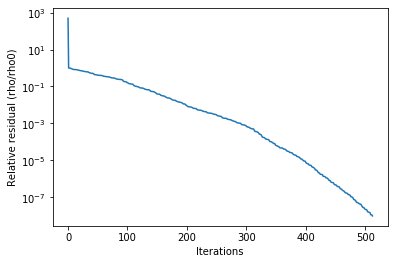

-> Full GMRES converged in 512 iterations (corresponds to the size of K-space). Relative residual = 9.759648001903562e-09 
-> Time taken(s) = 163.14761233329773


In [10]:
x, rho, Vj = fGMRES(A1,x0,b)

### Visualizing the solution vector x
For our linear system, we should get a 'all one' solution vector, which is what we are getting.

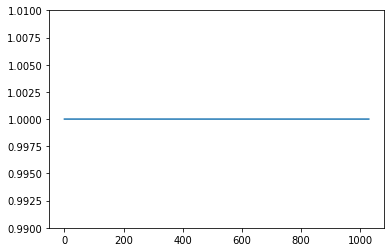

In [11]:
plt.plot(x)
plt.ylim(0.99,1.01)
plt.show()

### Orthogonality of the Krylov vectors from Full GMRES

While Gram Schmidt is expected to generate orthogonal vectors, it suffers with maintaining the orthogonality as the Krylov space becomes bigger. This can be observed when we plot dot products of all the vectors with the first vector. Ideally, it should always be a constant zero. But it increases from 1e-18 for early vectors to 1e-4 for the later vectors.

Using $V_m$ matrix containing $m$ Krylov vectors to plot the dot product values $(v_1,v_k)$ against $k$ where $k=1,2,...,m$ on a semi-log scale.

As the number of generated Krylov vectors increases, the new vectors exponentially lose their orthogonality with the first vector. This loss of orthogonality in larger Krylov spaces leads to a decrease in the rate of convergence as it becomes harder and harder to find newer directions for improving the solution vector. 

Therefore, it is better to find the solution in smaller Krylov spaces, which motivates the use of preconditioning and restarted-GMRES (up next). 

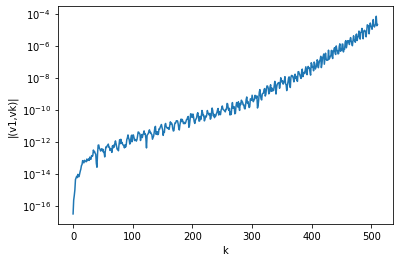

In [12]:
dp=[]
for j in range(1,len(Vj)):
    dp.append(abs(dotProduct(Vj[0],Vj[j])))
        
plt.semilogy(dp)
plt.ylabel("|(v1,vk)|")
plt.xlabel("k")
plt.show()

## Full-GMRES (with preconditioning)

The idea of pre-conditioning is to solve 'nicer' system, instead of the original one, that converges faster and then retrieving the solution for the original system. Essentially, we transform into a system that has more clustered eigenvalues which improves the performance of iterative solvers. Here, we use left-preconditioning where we solve the following system: $M^{-1} A x = M^{-1} b$. Matrix M should be similar to A in some sense and more importantly, it should be easy to invert. 

One way will be to use $M=A$, but that will result in the original problem of getting $A^{-1}$. Other ways will be to use $M=diag(A)$, a method known as Jacobi preconditioning, or $M=lowerTriangle(A)$, a method known as Gauss-Seidel preconditioning. $M^{-1}$ for Jacobi preconditioning is trivial to calculate (inverse of a diagonal matrix) and for Gauss-Seidel, we can get the inverse using forward substitution to solve $Mw=z$ to get $w=M^{-1}z$. 

We have implemented both of these methods in the function `pcGMRES`. 

In [13]:
def pcGMRES(A,x0,b,preconditioning):
    m=1000
    '''preconditioning argument is used to select the type of preconditioning to be applied
            1 -> Jacobi preconditioning
            2 -> Gauss-Seidel preconditioning
    '''    
    def mGetKrylov(A,Vj,preconditioning):
        vj= Vj[-1]                             
        hj= [0 for i in range(len(Vj))]        
        
        z = matVecProductCRS(A,vj)
        if preconditioning == 1:                               # preconditioning is applied at every iteration
            w = diagonalInverseMultCRS(A,z)
               
        elif preconditioning == 2:
            w = forwardSubCRS(M,z)
         
        else:
            print("Error in mGetKrylov")
            return 0
    
        for i in range(len(Vj)):               
            vi= Vj[i]                         
            hj[i]= dotProduct(w,vi)           
            w = add(w, constMultiply(vi,-hj[i]))
    
        hj.append(norm(w))              
        vjnext = constMultiply(w,1/hj[-1])
    
        return vjnext, hj
    
    start = time.time()
    rholist=[]
    
    lhs= matVecProductCRS(A,x0)
    
    r0init = add(b,constMultiply(lhs,-1))     # r0init = b-(A)(x0)   -- residual before preconditioning
    
    if preconditioning == 1:
        r0 = diagonalInverseMultCRS(A,r0init)
    
    elif preconditioning == 2:
        M = lowerTriangleCRS(A)
        r0 = forwardSubCRS(M,r0init) 
        
    else:
        print("Error in pcGMRES")
        return 0
    
    
    v1 = constMultiply(r0,1/norm(r0))         # v1 = r0/norm(r0)     -- residual r0 after preconditioning      
    
    g = []
    g.append(norm(r0))
    rholist.append(norm(r0))
                          
    # for easy of access Vj and Hbar has vectors arranged row-wise (instead of col-wise which is usual notation in theory)
    
    Vj=[]
    Hbar=[]                       
    
    c = [0 for i in range(m)]
    s = [0 for i in range(m)]

    Vj.append(v1) 
    
    for j in range(m):
        
        vjnext, hj = mGetKrylov(A, Vj,preconditioning)
                
        for k in range(1,j+1): 
            val1   =  c[k-1]*hj[k-1] + s[k-1]*hj[k]
            val2   = -s[k-1]*hj[k-1] + c[k-1]*hj[k]
            hj[k-1]= val1
            hj[k]  = val2
    
        c[j]= hj[j]/(hj[j]**2 + hj[j+1]**2)**0.5
        s[j]= hj[j+1]/(hj[j]**2 + hj[j+1]**2)**0.5
    
        hj[j]= hj[j]*c[j] + hj[j+1]*s[j]
        #hj[j+1]=0                      # should be zero after rotation
    
        g.append(-s[j]*g[j])
        g[j]  =  c[j]*g[j]
            
        for num in range(m-1-j):
            hj.append(0)
            
        Hbar.append(hj)
        Vj.append(vjnext)
        
        rholist.append(abs(g[j+1])/rholist[0])
        #print("Generated",j+1,"Krylov vectors. Relative residual=",abs(g[j+1])/rholist[0],flush=True)
            
        if abs(g[j+1])/rholist[0] < 1e-8:
            break
    
    if j!=m-1:
        Hbart=transpose(Hbar)     # removing the rows containing all zeros in a case loops breaks before iterating m times
        for i in range(m-j-1):
            Hbart.pop()
        Hbar= transpose(Hbart)
    
    Vj.pop()                        # remove m+1 th vector

    print(len(g))
    rho= abs(g.pop())               # |g_m+1| is nothing but rm
    
    # removing the last row of Hbar giving Hm matrix
    Hbart=transpose(Hbar)
    Hbart.pop()                 
    H= transpose(Hbart)             # gives out transpose of Hm matrix
    
    xm = add(x0, matVecProduct(transpose(Vj), backSub(transpose(H),g)))
    
    end = time.time()
    plt.semilogy(rholist)
    plt.xlabel("Iterations")
    plt.ylabel("Relative residual (rho/rho0)")
    plt.show()
    
    if rholist[-1] > 1e-8:
        print("-> Full GMRES with preconditioning did not converge after",m,"iterations. Relative residual =",rholist[-1], "\n-> Time taken(s) =", end-start)
    else:
        print("-> Full GMRES with preconditioning converged in", len(Vj), "iterations (corresponds to the size of K-space). Relative residual =", rholist[-1], "\n-> Time taken(s) =", end-start)   

    return x, rholist[-1]

### Jacobi preconditioning

One can observe that the number of Krylov vectors generated to converge is 293 (instead of 512 in case of full GMRES). This leads to a faster convergence, which can be seen from the decrease in time for computation as well, and the slope of the relative-residual vs iteration which remains fairly constant (constant convergence rate). 

294


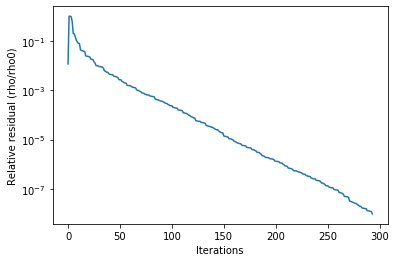

-> Full GMRES with preconditioning converged in 293 iterations (corresponds to the size of K-space). Relative residual = 9.682425353852285e-09 
-> Time taken(s) = 51.46000337600708


In [14]:
x, rho = pcGMRES(A1,x0,b,1)

### Gauss-Seidel preconditioning
Similarly, Gauss-Seidel preconditioning leads to a uniform convergence rate and faster convergence time. It uses even fewer Krylov vectors to converge than Jacobi preconditioning.

290


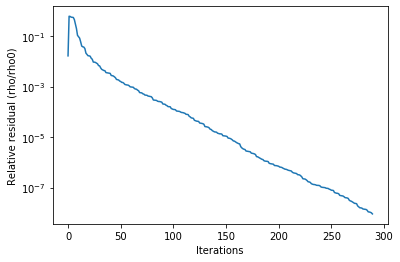

-> Full GMRES with preconditioning converged in 289 iterations (corresponds to the size of K-space). Relative residual = 9.173158720467654e-09 
-> Time taken(s) = 41.9298255443573


In [15]:
x, rho = pcGMRES(A1,x0,b,2)

## Parameter study for Restarted-GMRES(m)

Restarted-GMRES(m) uses an outer loop that iterates over m-dimensional Krylov space (m is fixed) where each new outer iteration takes the initial guess from the solution of the last outer iteration. Within the outer loop, GMRES iterated m-times with improved initial guesses. We have implemented it in function `rGMRES`

In [16]:
def rGMRES(A,x0,b,m):
    start=time.time()
    
    cutoff = 1e-8
    rholist=[]
    
    lhs = matVecProductCRS(A,x0)
    rho0 = norm(add(b,constMultiply(lhs,-1)))
    
    count=0
    
    x = x0
    rho = rho0  
   
    while rho/rho0 > cutoff and count<=1000: 
        x, rho, Vj = GMRES(A,x,b,m,False)
        rholist.append(rho/rho0)
        count=count+1
        #print("->> Iteration", count, "completed. Relative residual=", rho/rho0, flush=True)
        
    
    end=time.time()
        
    plt.semilogy(rholist)
    plt.xlabel("Iterations")
    plt.ylabel("Relative residual (rho/rho0)")
    plt.show()
    
    if count==1001:
        print("-> Restarted GMRES with m =", m, "did not converge after 1000 iterations. Relative residual =", rho/rho0, "\n-> Time taken(s) =", end-start)
    else:
        print("-> Restarted GMRES with m =", m, "converged in", count, "iterations. Relative residual =", rho/rho0, "\n-> Time taken(s) =", end-start)
    
    return x, rho, end-start

This implementation of GMRES gives significant time boost over full-GMRES as the size of the Krylov space can be controlled, and hence the convergence rate can be controlled in a way. However, the choice of `m` for restarted-GMRES is not trivial.

We conduct a parameter study to find the best m for our linear system by observing the time of convergence. We run the `rGMRES(m)` for `m = 150, 100, 50, 30, 10` followed by finer test for `m = 40, 75, 35, 45`. We then plotted the results and made some observations. 


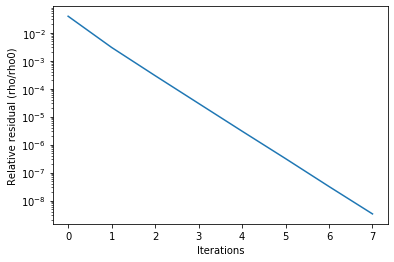

-> Restarted GMRES with m = 150 converged in 8 iterations. Relative residual = 3.3568905228091366e-09 
-> Time taken(s) = 73.72387051582336


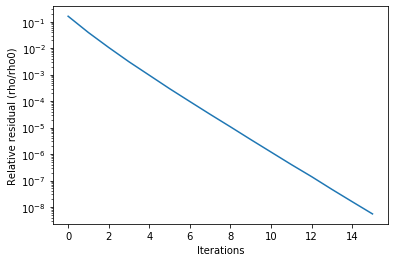

-> Restarted GMRES with m = 100 converged in 16 iterations. Relative residual = 5.470739850106003e-09 
-> Time taken(s) = 72.20494651794434


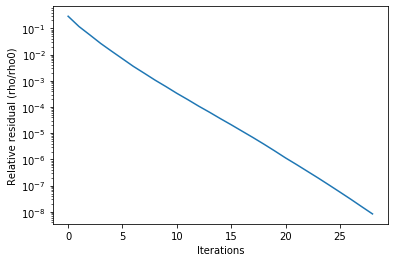

-> Restarted GMRES with m = 75 converged in 29 iterations. Relative residual = 8.34920362870508e-09 
-> Time taken(s) = 77.24398970603943


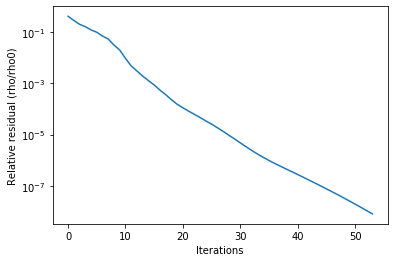

-> Restarted GMRES with m = 50 converged in 54 iterations. Relative residual = 8.029361375569321e-09 
-> Time taken(s) = 71.5304582118988


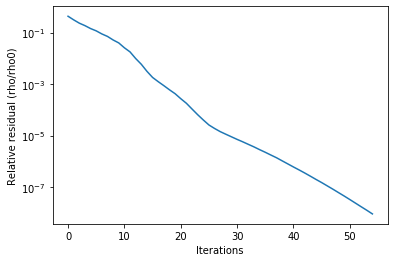

-> Restarted GMRES with m = 45 converged in 55 iterations. Relative residual = 8.91665985497691e-09 
-> Time taken(s) = 56.91808009147644


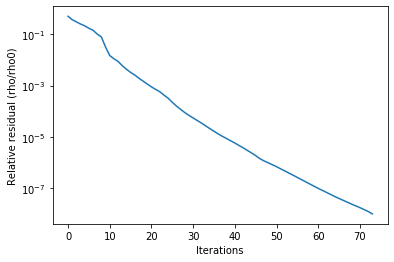

-> Restarted GMRES with m = 40 converged in 74 iterations. Relative residual = 9.90638556826397e-09 
-> Time taken(s) = 63.641481161117554


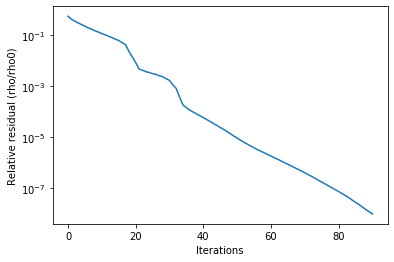

-> Restarted GMRES with m = 35 converged in 91 iterations. Relative residual = 9.449869251049978e-09 
-> Time taken(s) = 66.53681898117065


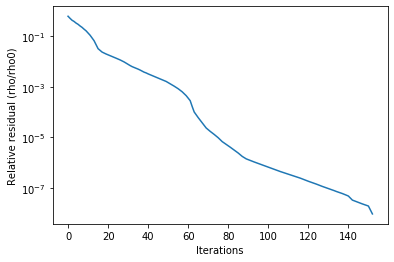

-> Restarted GMRES with m = 30 converged in 153 iterations. Relative residual = 9.422443228838328e-09 
-> Time taken(s) = 85.92061376571655


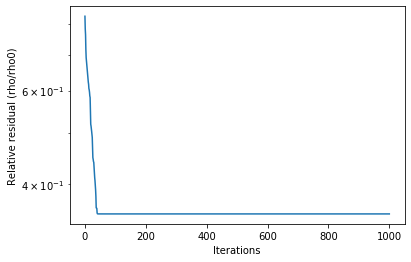

-> Restarted GMRES with m = 10 did not converge after 1000 iterations. Relative residual = 0.3514967001861833 
-> Time taken(s) = 101.41985392570496


In [17]:
t=[0]*9
x, rho, t[8] = rGMRES(A1,x0,b,150)
x, rho, t[7] = rGMRES(A1,x0,b,100)
x, rho, t[6] = rGMRES(A1,x0,b,75)
x, rho, t[5] = rGMRES(A1,x0,b,50)
x, rho, t[4] = rGMRES(A1,x0,b,45)
x, rho, t[3] = rGMRES(A1,x0,b,40)
x, rho, t[2] = rGMRES(A1,x0,b,35)
x, rho, t[1] = rGMRES(A1,x0,b,30)
x, rho, t[0] = rGMRES(A1,x0,b,10)

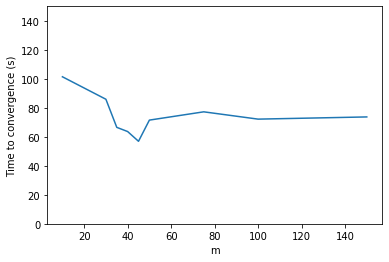

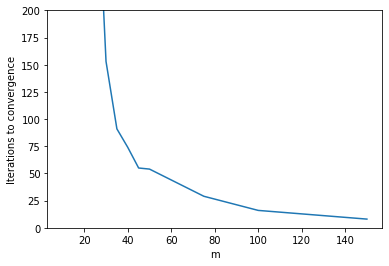

In [27]:
# plotting time of computation against m
m = [10, 30, 35, 40, 45, 50, 75, 100, 150]
iterations = [1000, 153, 91, 74, 55, 54, 29, 16, 8]

plt.plot(m, t)
plt.ylim(0,150)
plt.ylabel("Time to convergence (s)")
plt.xlabel("m")
plt.show()

plt.plot(m, iterations)
plt.ylim(0,200)
plt.ylabel("Iterations to convergence")
plt.xlabel("m")
plt.show()

#### Observations
1. Convergence time for all restart parameters m (except m = 10) is lower than that for full-GMRES (without preconditioning).
2. Convergence time decreases and then increases as we go down from m = 150 to m = 10.
3. At m = 10, the convergence does not happen after 1000 outer loop iterations (10000 GMRES iterations). 
4. Fastest convergence is observed for m = 45.

#### Discussions

For smaller `m`, Krylov space vectors are too less for a sufficiently fast convergence rate. It takes more outer loop iterations over the smaller K-space to converge, adding to the computation time. In fact, in our example for `m = 10`, the convergence seemingly stops after ~50 outer loop iterations (taking 'infinite' time for convergence).

For larger `m`, Krylov space is too big for faster convergence. Even though convergence happens in fewer outer loop iterations, each of it takes lots of time to compute over a larger K-space. An extreme example of restarted-GMRES will be full-GMRES where only one outer loop iteration does all the heavy-lifting with a large Krylov space (512 Krylov vectors in our case).

There is an optimum `m` which balances the time per iteration and number of iterations needed. For our example, `m* = 45` is optimum `m` with minimum convergence time.

Moreover at higher `m`, orthogonality of Krylov space is lost as the number of vectors increases. In our linear system, we found that for `m ~ 500`, we already had a significantly large dot product (1e-4) for two supposedly orthogonal vectors. This gets worse as `m` increases further. Using `GramSchmidt` to generate Krylov space with 1000 Krylov vectors (figure below) gives dot products $(v_1,v_k)$ in the range 1e-2. Imagine working with an ill-conditioned linear system that requires more iterations in full-GMRES mode or restarted-GMRES with bigger `m`. In such a case, as the orthogonality of the vectors decreases, the improvement in solution vector also decreases as the vectors point to less and less 'unique directions'. As such, the algorithms might not even converge. Therefore, restarted GMRES with not so large `m` is a better option.


-> Krylov space with  1000  vectors generated. 



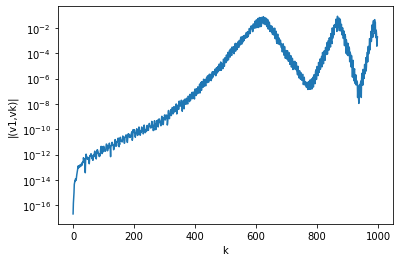

In [19]:
lhs= matVecProductCRS(A1,x0)
r0 = add(b,constMultiply(lhs,-1))
Vj, Hbar = GramSchmidt(A1,r0,1000)

dp=[]
for j in range(1,len(Vj)):
    dp.append(abs(dotProduct(Vj[0],Vj[j])))
        
plt.semilogy(dp)
plt.ylabel("|(v1,vk)|")
plt.xlabel("k")
plt.show()

# Conjugate Gradients (CG) Method

CG is a Krylov-space method for solving linear systems where convergence is gauranteed if A is a symmetric positive-definite matrix. It is a smart implementation of conjugate directions that minimizes the quadratic form $f(x) = \frac{1}{2} x^T A x - x^T b + c$, which is equivalent to solving the linear system $Ax = b$. 

Essentially, the solution of the current iteration is approximated in a search direction that is chosen using an optimizing criterion. The search direction is globally optimal through construction. The implementation allows solution and residual updates without long recurrence as the new search direction only depends on the most previous one.

We have implemented the algorithm in the function `conjGrad`.

In [20]:
def conjGrad(A,x,b):

    start = time.time()
    rholist=[]
    errlist=[]
    cutoff = 1e-8
    
    lhs = matVecProductCRS(A,x)
    r = add(b,constMultiply(lhs,-1))                      # r0 = b - (A)(x0)
    p=r                                                   # pm = p0 = r0
    rs0= dotProduct(r,r)                                  # rs0 represents square of rho0
    rs_old = rs0 
    
 
    rholist.append((rs_old/rs0)**0.5)
    xsol = [1 for i in range(5357)]
    err = add(x, constMultiply(xsol,-1))
    errlist.append(dotProduct(matVecProductCRS(A,err), err)**0.5)
    errcount=[0]
    
    i=0
    while rholist[-1] > cutoff: 
        i=i+1
        
        Ap= matVecProductCRS(A,p)
        alpha = rs_old/dotProduct(p,Ap)
        
        x = add(x, constMultiply(p, alpha))
        r = add(r, constMultiply(Ap, -alpha))
        
        rs_new = dotProduct(r,r)
        beta = rs_new/rs_old              
        p = add(r, constMultiply(p, beta))  
        rs_old = rs_new
        
        rholist.append((rs_old/rs0)**0.5)
        
        if i%100==0:
            err = add(x, constMultiply(xsol,-1))
            errlist.append(dotProduct(matVecProductCRS(A,err), err)**0.5)       # introduces additional mat-vec product
            errcount.append(i)
            #print("->> Iteration", i, "completed. Relative residual =",rholist[-1], flush=True)
   
    end = time.time()
    
    plt.semilogy(rholist)
    plt.title("Relative residual against iteration index")
    plt.xlabel("Iterations")
    plt.ylabel("Relative residual (rho/rho0)")
    plt.show()
    
    rholist_abs = constMultiply(rholist, rs0**0.5)
    plt.semilogy(rholist_abs)
    plt.title("Absolute residual in 2-norm against iteration index")
    plt.xlabel("Iterations")
    plt.ylabel("Residual (rho)")
    plt.show()
    
    plt.semilogy(errcount,errlist)
    plt.title("Error in A-norm against iteration index")
    plt.xlabel("Iterations")
    plt.ylabel("Error (||e||_A)")
    plt.show()
        
    print("-> CG converged in",i,"iterations. Relative residual =",rholist[-1],"\n-> Time taken =",end-start, "seconds")

    return x, rs_new**0.5

## Setting up the linear system and using CG
We set up the linear system Ax=b where A is symmetric sparse-matrix s3rmt3m3.mtx and x is [1,1,..,1]. 
b is computed using matrix-vector product Ax. Then, the solution for Ax = b is found using CG method.

In [21]:
A2_dense=sio.mmread("s3rmt3m3.mtx").toarray()
A2=denseToCRS(A2_dense)

xsol = [1 for i in range(5357)]
b = matVecProductCRS(A2, xsol)
x0 = [0 for i in range(5357)]

-> Symmetric
-> Converted to CRS format
-> Length of vectors I,J,V:  5358 106240 106240


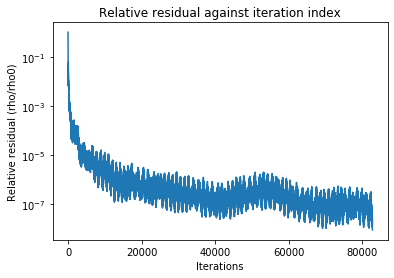

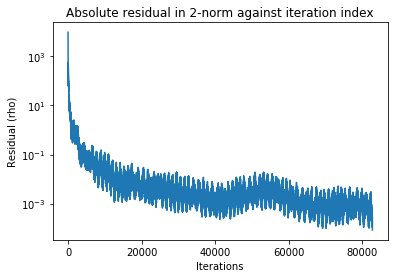

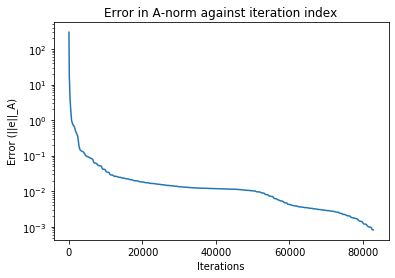

-> CG converged in 82801 iterations. Relative residual = 8.885048968377784e-09 
-> Time taken = 9116.203913450241 seconds


In [22]:
x, rho = conjGrad(A2,x0,b)

## Visualizing the solution vector x

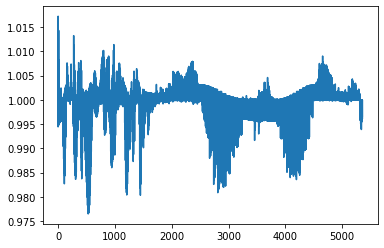

In [23]:
plt.plot(x)
plt.show()

## Observations and Discussions
1. The number of iterations are significantly higher than we saw in GMRES method. This can be probably because the matrix size used for CG has 5-times the number of rows or columns than that of the matrix used for GMRES. Runtime in Python without using numpy is approximately 2.5 hours whereas the same implementation in C++ takes around 3 minutes (an estimate from fellow classmate).

2. Solution vector visualization shows that while the relative residual cutoff of 1e-8 is fulfilled, the absolute error is somewhat non-trivial. One should use a more strict relative residual cutoff for production runs. 

3. Relative residual norm fluctuates while overall decreasing as the iterations progress. Interestingly, these fluctuations are not visible when error in A-norm is plotted against iterations. This is because by construction, CG minimizes the error in A-norm over the Krylov space instead of the residual in 2-norm. Therefore, we have no guarantees for monotonically decreasing residual. The fluctuations in residual can arise when it is scaled in the direction of a bad eigenvector (with $>>1$ eigenvalue) of the ill-conditioned A matrix.   

# Post script comments
Using Python without numpy came with some uninvited implementation challenges. Along with higher runtimes, there were certain access challenges while using list data structure for matrices. It seemed easier to store Krylov vectors in $V_j$ or columns of  $\overline{H}_m$ as lists, which would correspond to storing them as rows when accessing. But this also required performing repeated transposes at some places, especially when we wanted to remove the last row of $\overline{H}_m$. We identified that the current implementation isn't the best one. 

Moreover, as scipy imports .mtx as an object, we couldn't find a way to get pure COO output in a list.  Therefore, we used .toarray() method to get matrix in dense format, after which the matrix was converted from dense to CRS format.   

***